# Model testing
This notebook is used to test the results of the trained model on the witheld test set

In [10]:
import pandas as pd
import numpy as np
import os
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [2]:
class MultiModalDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with image paths, numeric features, and labels.
            image_dir (str): Directory where images are stored.
            transform (callable, optional): Optional transform to be applied on a PIL image.
        """
        # Attributes to maintain and manage different parts of the dataset
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

        # Numeric/ feature columns from the dataset
        # Note removed null columns and meaningless columns (e.g., X and Y locations in mosaic)
        self.feature_cols = [
            'Area..ABD.', 'Area..Filled.',
            'Aspect.Ratio', 'Calibration.Factor', 'Calibration.Image',
            'Circle.Fit', 'Circularity', 'Circularity..Hu.', 'Compactness',
            'Convex.Perimeter', 'Convexity', 'Diameter..ABD.', 'Diameter..ESD.',
            'Diameter..FD.', 'Edge.Gradient', 'Elongation', 'Feret.Angle.Max',
            'Feret.Angle.Min', 'Fiber.Curl', 'Fiber.Straightness', 'Filter.Score',
            'Geodesic.Aspect.Ratio', 'Geodesic.Length', 'Geodesic.Thickness',
            'Image.Height', 'Image.Width', 'Intensity', 'Length',
            'Particles.Per.Chain', 'Perimeter', 'Roughness', 'Sigma.Intensity',
            'Source.Image', 'Sphere.Complement', 'Sphere.Count', 'Sphere.Unknown',
            'Sphere.Volume', 'Sum.Intensity', 'Symmetry', 'Transparency',
            'Volume..ABD.', 'Volume..ESD.', 'Width']

        self.label_col = "int_labels" # Class label
        self.path_col = "resized_filepath" # Filepath of resized image (50x50)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Row number to be returned

        Returns:
            dict: A dictionary containing:
                - 'image' (torch.Tensor): Transformed image tensor of shape [1, H, W]
                - 'numerical' (torch.Tensor): Tensor of numeric features of shape [num_features] 
                - 'label' (torch.Tensor): Integer tensor containing the class label
        """
        row = self.data.iloc[idx] # Get relevant row from dataset

        # Load image
        img_path = os.path.join(self.image_dir, row[self.path_col])
        image = Image.open(img_path).convert("L")  # Ensure grayscale ("L" mode)

        if self.transform:
            image = self.transform(image)  # e.g. ToTensor, Normalize, etc.

        # Numeric features
        numeric_feats = torch.tensor(np.array(row[self.feature_cols].tolist(), dtype=np.float32)) # Ensure all numeric

        # Label
        label = torch.tensor(row[self.label_col], dtype=torch.long)

        return {
            'image': image,          # shape: [1, H, W] after transform
            'numerical': numeric_feats,  # shape: [num_features]
            'label': label
        }


# Build model
class MultiModalNet(nn.Module): 
    def __init__(self, num_numeric_features= 43, num_classes=9):
        """
        Args:
            num_numeric_features: Number of numeric input features (e.g., 3).
            num_classes: Number of output classes for final classification.
        """
        super(MultiModalNet, self).__init__()

        # Load the pretrained EfficientNet model
        self.effnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

        # Modify EfficientNetModel for 1 channel and 50x50 images
        old_conv = self.effnet.features[0][0]  # first Conv2d layer
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride= 1, #old_conv.stride,
            padding=old_conv.padding,
            bias=old_conv.bias
        )

        # Copy over/average the weights from 3 channels into 1
        with torch.no_grad():
            new_conv.weight = nn.Parameter(torch.mean(old_conv.weight, dim=1, keepdim=True))
        self.effnet.features[0][0] = new_conv
        effnet_out_dim = self.effnet.classifier[1].in_features

        # Replace the classifier with an identity operation so we can get raw features
        self.effnet.classifier = nn.Identity()

        # Build Feed Forward network for numeric data
        self.ff = nn.Sequential(
            nn.Linear(num_numeric_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        ff_out_dim = 32

        # Combine two sub networks
        combined_dim = effnet_out_dim + ff_out_dim
        self.classifier = nn.Linear(combined_dim, num_classes)

    def forward(self, image, numeric):
        # 1) Extract features from EfficientNet
        cnn_features = self.effnet(image)  # shape: [batch_size, 1280]

        # 2) Extract features from feed-forward layers
        ff_features = self.ff(numeric)     # shape: [batch_size, 32]

        # 3) Concatenate
        combined = torch.cat([cnn_features, ff_features], dim=1)  # [batch_size, 1280 + 32]

        # 4) Classify
        logits = self.classifier(combined) # [batch_size, num_classes]
        return logits


# Test prediction abilities
def test_one_epoch(model, dataloader, device):
    model.eval()
    confusion_matrix = torch.zeros(9, 9)  # 9x9 matrix for 9 classes

    # We won't compute gradients during validation
    with torch.no_grad():
        for batch in dataloader:
            # Move to GPU
            images = batch['image'].to(device)
            numeric = batch['numerical'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images, numeric)
            _, preds = torch.max(outputs, 1)

            # Update confusion matrix
            for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    return confusion_matrix

In [ ]:
# Hyper parameters
img_size = 50
num_classes = 9
csv_file = r"data\merged_csv\combined_data.csv"  # CSV file with image paths, numeric features, and label
image_dir = r"data\EfficientNetTrain"              # Directory with images
batch_size = 256
num_epochs = 20
learning_rate = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Run on GPU if possible
print("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # Resize images to 50x50 pixels
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizing for grayscale images
])


# Build the dataset
full_dataset = MultiModalDataset(csv_file=csv_file, image_dir=image_dir, transform=transform)

#Split into 70% Train, 20% Validate, 10% test
indices = np.arange(len(full_dataset))
labels = full_dataset.data["int_labels"] # Collect labels

# First split: 90% (train+val) and 10% test
_, test_idx = train_test_split(indices, test_size=0.1, stratify=labels, random_state=42)
test_dataset = Subset(full_dataset, test_idx)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

model = MultiModalNet(num_numeric_features=43, num_classes= num_classes).to(device)
best_model_path = "best_multimodal_efficientnet_v2.pth"

model.load_state_dict(torch.load(best_model_path,map_location=torch.device('cpu')))
print("Loaded Model")
confusion_mat= test_one_epoch(model, test_loader, device)
# Save confusion matrix to file
np.save('confusion_matrix.npy', confusion_mat)
print("Saved confusion matrix to confusion_matrix.npy")



cpu
Transforming and preparing Dataset
Loaded Model


# Build confusion matrix

In [1]:
confusion_mat = np.load('confusion_matrix_vF.npy')
data = pd.read_csv(r"C:\Users\Welcome\Documents\MScAC\STA2453\Project\CodeRepo\STA2453-Zooplankton\data\merged_csv\combined_data.csv")


In [4]:
cols = data[['priority_class','int_labels']].drop_duplicates()

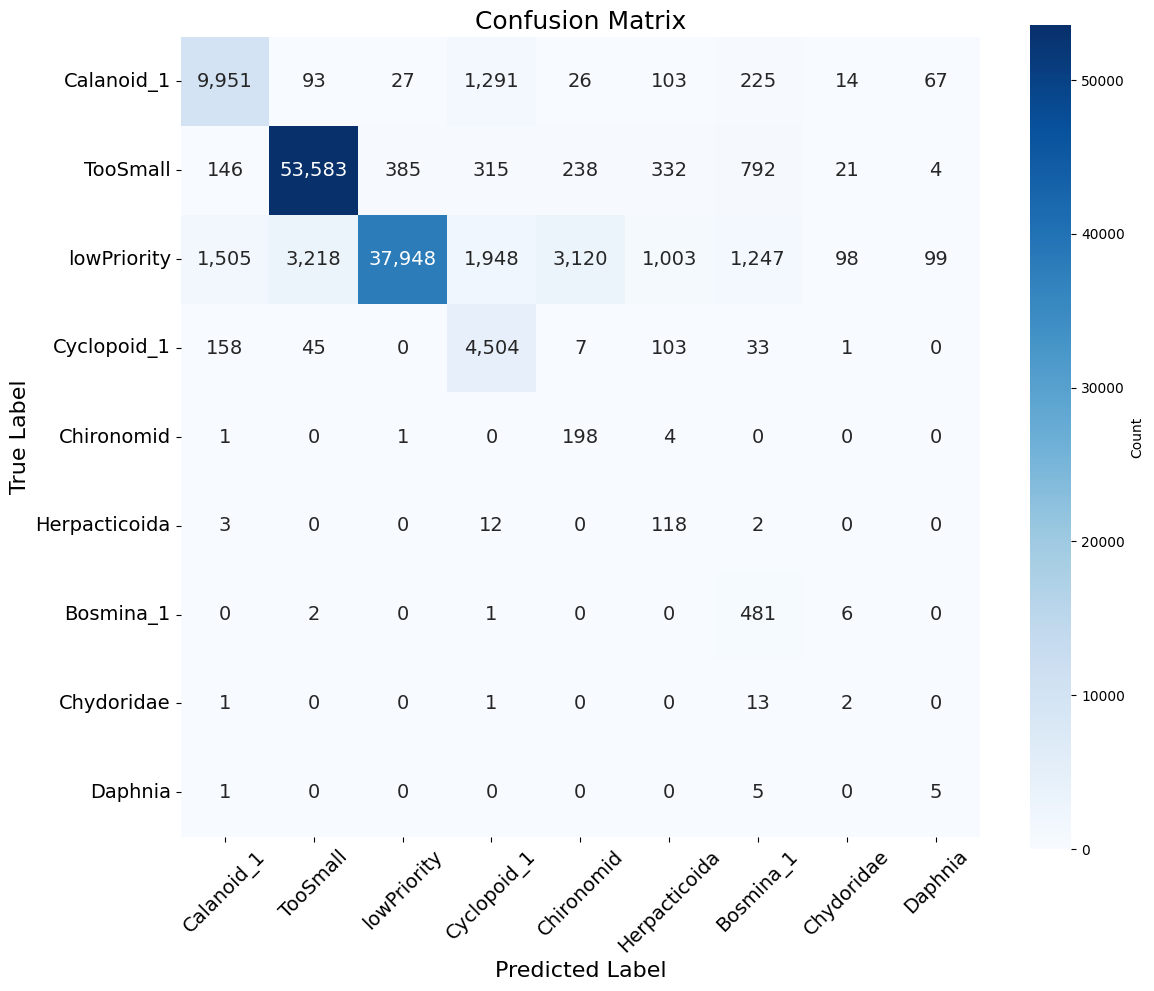

In [7]:
# Make confusion matrix
plt.figure(figsize=(12, 10))

# Create heatmap using seaborn
sns.heatmap(confusion_mat, 
            annot=True,  # Show numbers in cells
            fmt=',.0f',  # Use integer format
            cmap='Blues', # Color scheme
            cbar_kws={'label': 'Count'},
            square=True,
            xticklabels=cols['priority_class'].to_numpy(),
            yticklabels=cols['priority_class'].to_numpy(),
            annot_kws={"size": 14})  # Increase annotation font size

# Increase font size for tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Increase font size for tick label rotation (if needed)
plt.xticks(rotation=45, fontsize=14)  # Rotate if needed
plt.yticks(rotation=0, fontsize=14)   # Rotate if needed

# Add labels and title with larger font sizes
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.title('Confusion Matrix', fontsize=18)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()


In [9]:
conf_matrix = confusion_mat
num_classes = conf_matrix.shape[0]

# Initialize lists to store precision, recall, and F1 scores for each class
precision = []
recall = []
f1_scores = []

# Iterate over each class
for i in range(num_classes):
    # True Positives (TP) for class i is the diagonal element
    TP = conf_matrix[i, i]
    
    # False Positives (FP) for class i is the sum of the i-th column (excluding the diagonal)
    FP = np.sum(conf_matrix[:, i]) - TP
    
    # False Negatives (FN) for class i is the sum of the i-th row (excluding the diagonal)
    FN = np.sum(conf_matrix[i, :]) - TP
    
    # Precision = TP / (TP + FP)
    precision_i = TP / (TP + FP) if (TP + FP) != 0 else 0
    
    # Recall = TP / (TP + FN)
    recall_i = TP / (TP + FN) if (TP + FN) != 0 else 0
    
    # F1-score = 2 * (Precision * Recall) / (Precision + Recall)
    if (precision_i + recall_i) != 0:
        f1_score_i = 2 * (precision_i * recall_i) / (precision_i + recall_i)
    else:
        f1_score_i = 0
    
    # Append the results to the lists
    precision.append(precision_i)
    recall.append(recall_i)
    f1_scores.append(f1_score_i)

# Print Precision, Recall, and F1-score for each class
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1_scores)

# Calculate the macro-average F1-score (unweighted average of all class F1-scores)
macro_f1 = np.mean(f1_scores)

# Calculate the weighted-average F1-score (weighted by the support of each class)
# Support is the sum of the rows (number of true instances for each class)
support = np.sum(conf_matrix, axis=1)
weighted_f1 = np.average(f1_scores, weights=support)

print(f"Macro average F1-score: {macro_f1}")
print(f"Weighted average F1-score: {weighted_f1}")

Precision per class: [np.float32(0.845742), np.float32(0.9410267), np.float32(0.98923385), np.float32(0.5579782), np.float32(0.05516857), np.float32(0.0709561), np.float32(0.17190851), np.float32(0.014084507), np.float32(0.028571429)]
Recall per class: [np.float32(0.84351957), np.float32(0.95999354), np.float32(0.75614715), np.float32(0.92846835), np.float32(0.9705882), np.float32(0.8740741), np.float32(0.98163265), np.float32(0.11764706), np.float32(0.45454547)]
F1-score per class: [np.float32(0.8446293), np.float32(0.9504155), np.float32(0.8571267), np.float32(0.6970517), np.float32(0.10440284), np.float32(0.13125695), np.float32(0.29257908), np.float32(0.025157232), np.float32(0.05376344)]
Macro average F1-score: 0.43959808349609375
Weighted average F1-score: 0.8873428106307983
